<a href="https://colab.research.google.com/github/MajidNoorani/depression_tweet_transformer/blob/main/depression_tweet_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!pip install datasets

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Load dataset

In [3]:
# Load the dataset
dataset = load_dataset("ziq/depression_tweet")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27613
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 9204
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 9205
    })
})

In [4]:
df_train = pd.DataFrame({
    'text': dataset['train']['text'],
    'label': dataset['train']['label']
})

df_test = pd.DataFrame({
    'text': dataset['test']['text'],
    'label': dataset['test']['label']
})

df_val = pd.DataFrame({
    'text': dataset['validation']['text'],
    'label': dataset['validation']['label']
})

In [5]:
df_train['label'].value_counts()

0    15655
1    11958
Name: label, dtype: int64

## analyse sequences
we need to find the maximum length of sequences because positional embedding requires this

In [6]:
max_words_length = df_train['text'].apply(lambda x: len(str(x).split())).max()

print("Maximum number of words in text:", max_words_length)

max_words_index = df_train['text'].apply(lambda x: len(str(x).split())).idxmax()

print("Index of the row with maximum number of words:", max_words_index)

Maximum number of words in text: 4239
Index of the row with maximum number of words: 1587


Only the first two sequences lengthes are more than 2000 and the rest of them are less than this value

In [7]:
sorted(df_train['text'].apply(lambda x: len(str(x).split())), reverse=True)[:10]

[4239, 2676, 2081, 1796, 1656, 1653, 1559, 1537, 1470, 1462]

<Axes: >

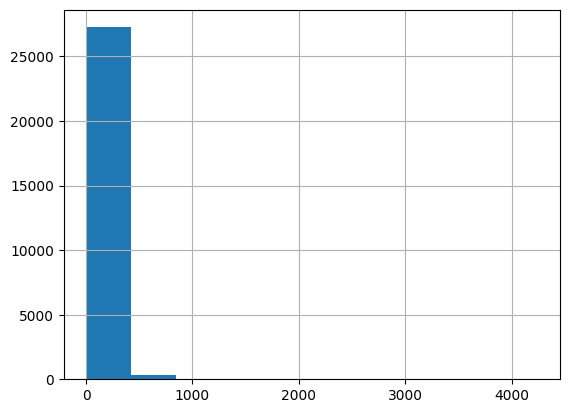

In [8]:
df_train['text'].apply(lambda x: len(str(x).split())).hist()

There are 76895 unique words in the whole training dataset

In [9]:
unique_words = len(set(" ".join(df_train['text'].astype(str)).split()))
unique_words

76895

# Model Blocks
we use transformers with multihead attention for the classification

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Embedding layers
positional embedding is for transformers

In [11]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Tokenizer

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
                num_words=None,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                lower=True,
                split=' ',
                char_level=False,
                oov_token=None,
                analyzer=None,
            )

In [13]:
tokenizer.fit_on_texts(df_train['text'].values)

## data config

In [15]:
vocab_size = 70000  # Only consider the top vocab_size words
maxlen = 2000  # Only consider the first maxlen words of each text

## padding

In [16]:
print(len(df_train['text']), "Training sequences")
print(len(df_val['text']), "Validation sequences")
x_train = tokenizer.texts_to_sequences(df_train['text'].values)
x_val = tokenizer.texts_to_sequences(df_val['text'].values)
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen, padding='post', truncating='post')

27613 Training sequences
9204 Validation sequences


# Model hyperparameters

In [17]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

# Build Model

In [18]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

## Callbacks

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=3,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    )
    ]

# Train the model

In [20]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, df_train['label'], batch_size=64, epochs=20, validation_data=(x_val, df_val['label']), callbacks=callbacks
)

Epoch 1/20
432/432 [==============================] - 246s 553ms/step - loss: 0.4750 - accuracy: 0.7398 - val_loss: 0.2190 - val_accuracy: 0.9212
Epoch 2/20
432/432 [==============================] - 260s 602ms/step - loss: 0.1851 - accuracy: 0.9364 - val_loss: 0.1983 - val_accuracy: 0.9336
Epoch 3/20
432/432 [==============================] - 247s 571ms/step - loss: 0.1411 - accuracy: 0.9510 - val_loss: 0.2266 - val_accuracy: 0.9166
Epoch 4/20
432/432 [==============================] - 260s 601ms/step - loss: 0.0996 - accuracy: 0.9666 - val_loss: 0.2576 - val_accuracy: 0.9261
Epoch 5/20
432/432 [==============================] - 260s 603ms/step - loss: 0.0670 - accuracy: 0.9804 - val_loss: 0.2755 - val_accuracy: 0.9225


# Evaluate Model

In [21]:
x_test = tokenizer.texts_to_sequences(df_test['text'].values)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
probabilities = model.predict(x_test)

288/288 [==============================] - 27s 94ms/step


Since we have w nodes in the output, we need to transform the outputs to single labels

In [34]:
pred_test = np.argmax(probabilities, axis=1)

Confusion Matrix and f1 score of test set

In [36]:
test_f1 = f1_score(df_test['label'].values, pred_test)
test_cm = confusion_matrix(df_test['label'].values, pred_test)
test_tn, test_fp, test_fn, test_tp = confusion_matrix(df_test['label'].values, pred_test).ravel()

In [37]:
test_f1

0.9319974953036945

In [38]:
test_tn, test_fp, test_fn, test_tp

(4941, 233, 310, 3721)